# Libraries

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time

#Model training and evaluation libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, recall_score,  precision_score, f1_score
import joblib

#XAI tools
import shap
import lime
import lime.lime_tabular


# Data Collection

In [34]:
df = pd.read_excel("Dataset.XLSX")
df.head()

,id,Pca,UrineWBC,UrineRBC,Ultrasoundhypoechoicnodules,Prostaticcalculi,PV,PSA,fPSA,PSAD,...,RDW,Plt,Neutrophilcount,Lymphocytecount,Monocytecount,Eosinophilcount,Bloodglucose,gammaglutamyltranspeptidase,Creatinine,ALP
0,1,0,0,1,0,0,41.85792,7.78,0.73,0.185867,...,0.12,292.4,3.67,1.70,0.50,0.29,5.4869,40.0,76.0,89.0
1,2,0,0,0,1,0,81.85320,12.19,2.65,0.148925,...,0.14,193.5,4.53,1.37,0.46,0.06,4.7900,23.0,99.0,73.0
2,4,0,0,0,0,1,81.36180,16.50,2.36,0.202798,...,0.12,358.4,5.58,1.00,0.54,0.54,5.2900,54.0,68.0,95.0
3,5,0,0,0,1,1,29.87712,8.32,0.67,0.278474,...,0.16,257.4,4.53,3.23,0.51,0.15,6.2201,82.0,81.0,80.0
4,6,0,1,1,1,0,102.78528,2.22,0.50,0.021598,...,0.17,206.4,4.61,1.15,0.49,0.08,4.5316,21.0,83.0,67.0


# Data Overview

In [35]:
df.isnull().sum()

,0
id,0
Pca,0
UrineWBC,0
UrineRBC,0
Ultrasoundhypoechoicnodules,0
Prostaticcalculi,0
PV,0
PSA,0
fPSA,0
PSAD,0


In [ ]:
#drop unnessary and irrelevant models
df.drop(['id', 'ALP'], inplace=True, axis = 1)
df.describe()

In [37]:
df.info() #this code helps to check the data types and count of the features in the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Pca                          146 non-null    int64  
 1   UrineWBC                     146 non-null    int64  
 2   UrineRBC                     146 non-null    int64  
 3   Ultrasoundhypoechoicnodules  146 non-null    int64  
 4   Prostaticcalculi             146 non-null    int64  
 5   PV                           146 non-null    float64
 6   PSA                          146 non-null    float64
 7   fPSA                         146 non-null    float64
 8   PSAD                         146 non-null    float64
 9   FT                           146 non-null    float64
 10  Age                          146 non-null    int64  
 11  BMI                          146 non-null    float64
 12  NLR                          146 non-null    float64
 13  PLR                 

In [38]:
df.shape

(146, 30)

# EDA (Exploratory Data Analysis)

Target Variable Analysis

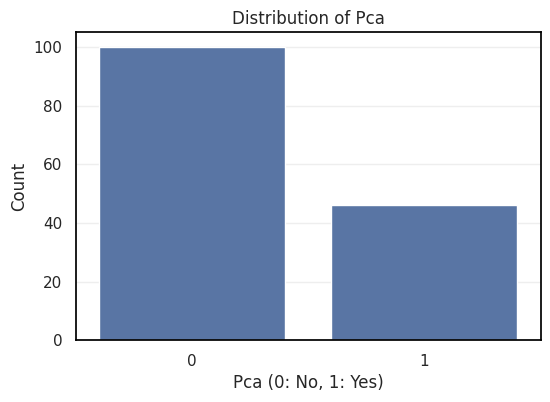

In [39]:
# Count plot for the target variable 'Pca' (binary classification)
plt.figure(figsize=(6, 4))
sns.countplot(x='Pca', data=df)
plt.title('Distribution of Pca')
plt.xlabel('Pca (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

Correlations

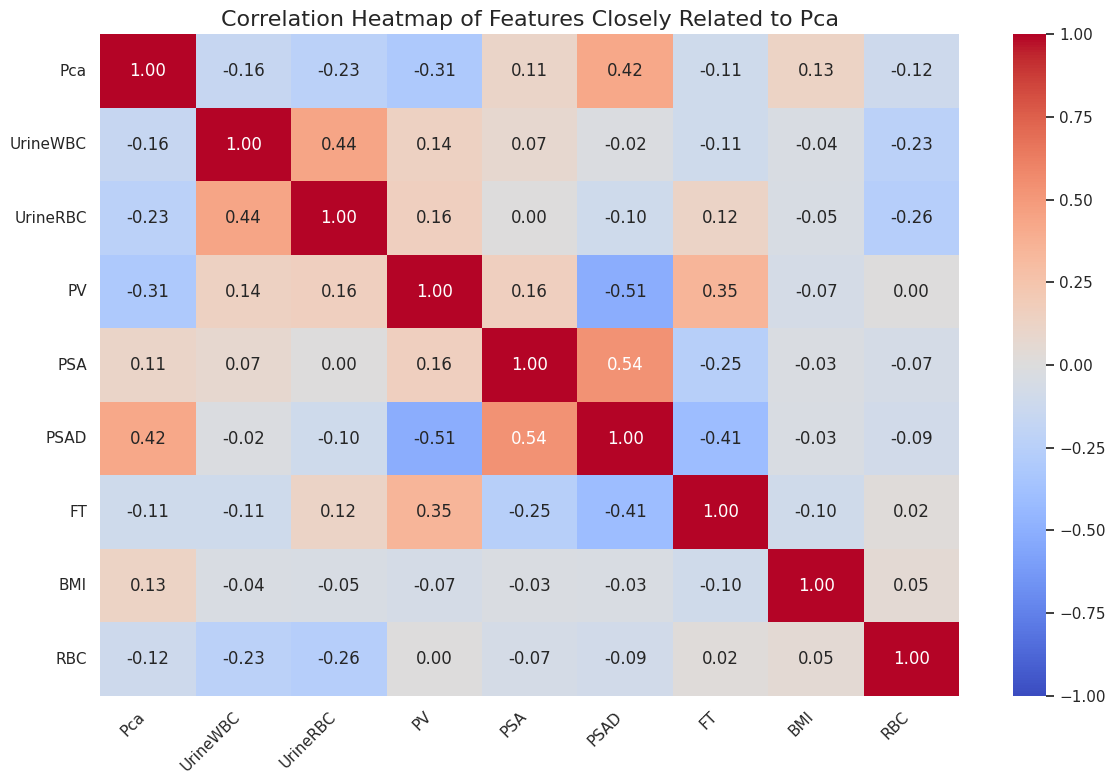

In [40]:
correlation = df.corr()

# Get absolute correlations with the target variable 'Pca'
target_corr = correlation['Pca'].abs()

# Filter for features with high correlation
# Adjust the threshold as per your analysis needs
high_corr_features = target_corr[target_corr > 0.1].index

# Subset the correlation matrix for highly correlated features
subset_corr = correlation.loc[high_corr_features, high_corr_features]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(subset_corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Features Closely Related to Pca", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Outliers check

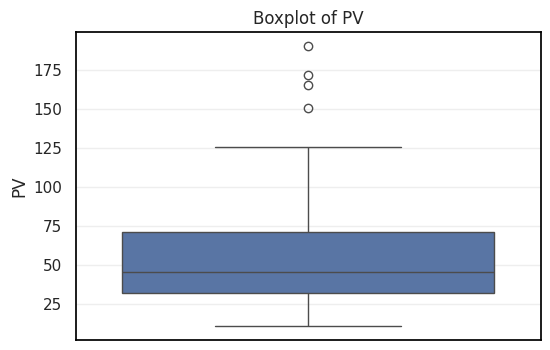

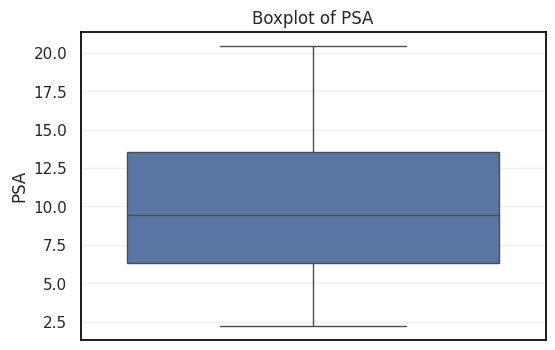

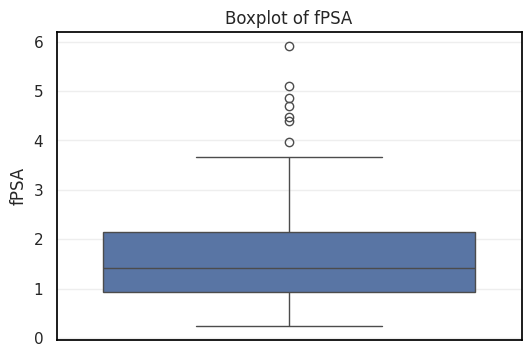

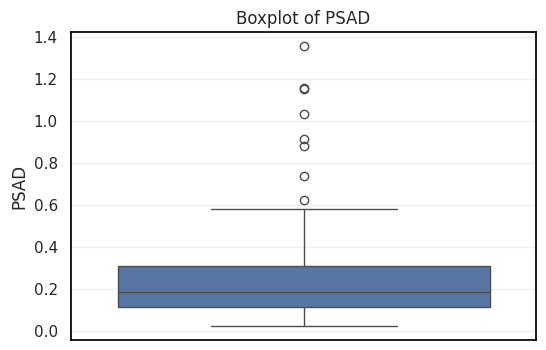

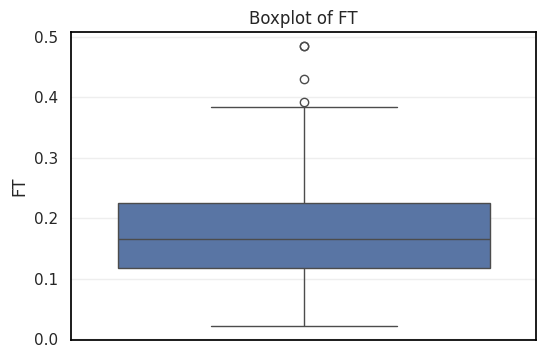

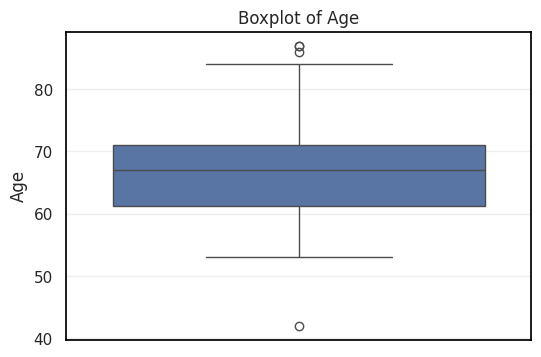

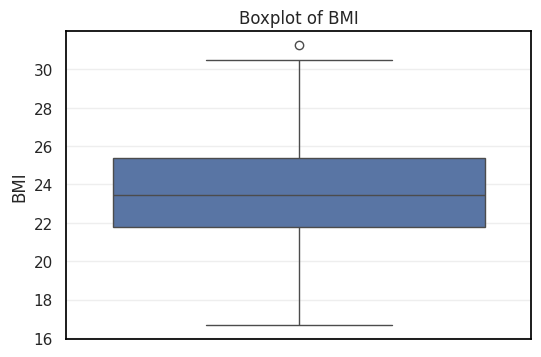

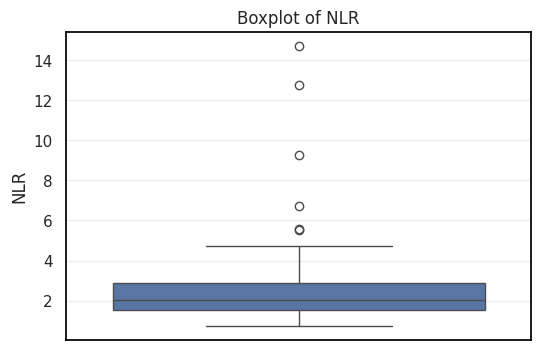

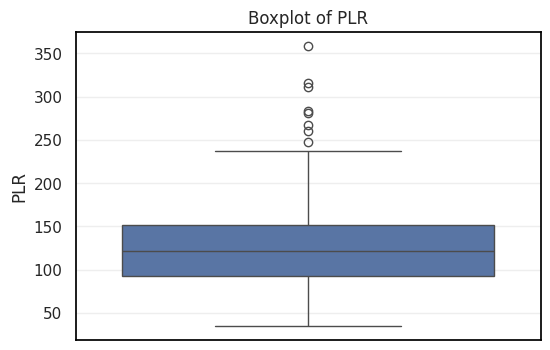

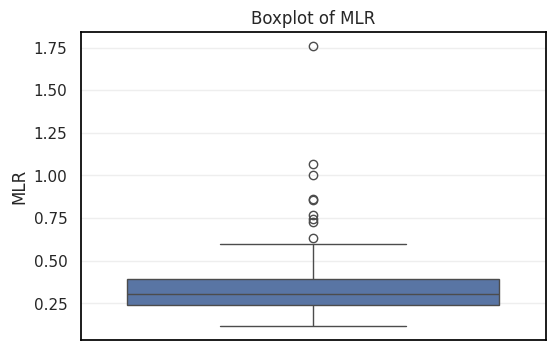

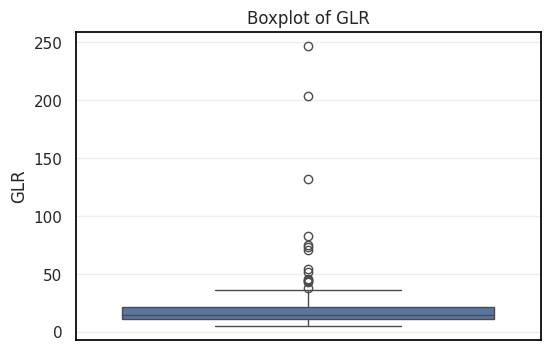

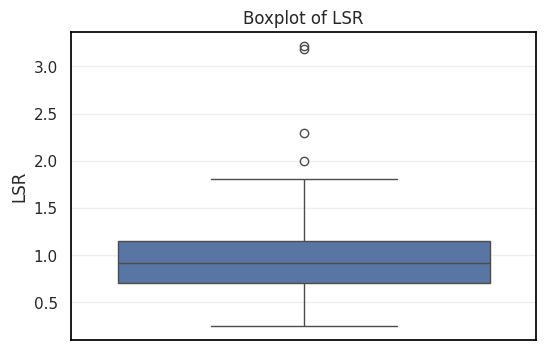

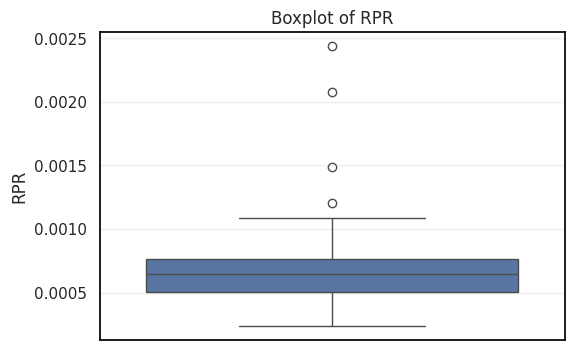

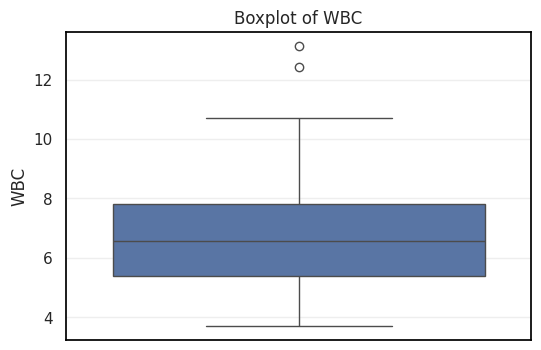

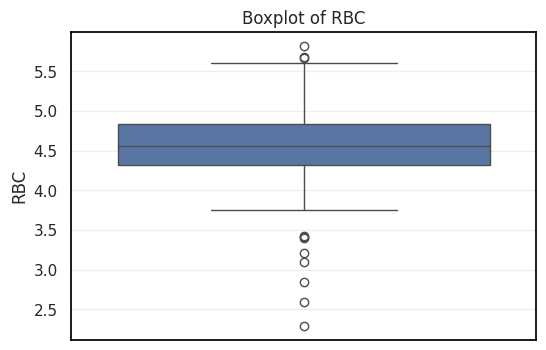

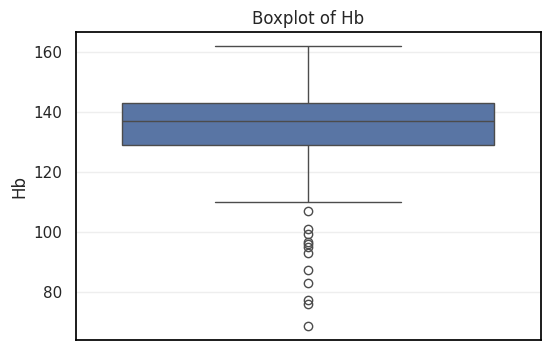

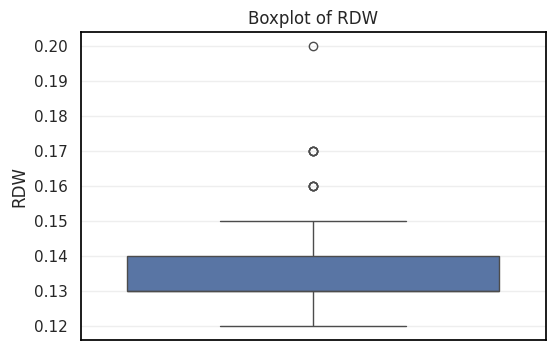

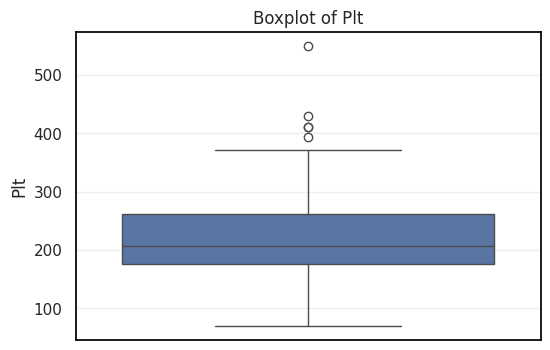

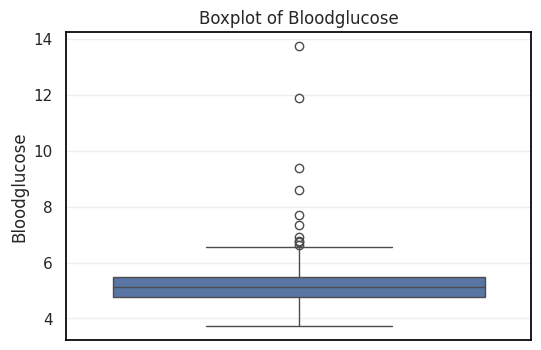

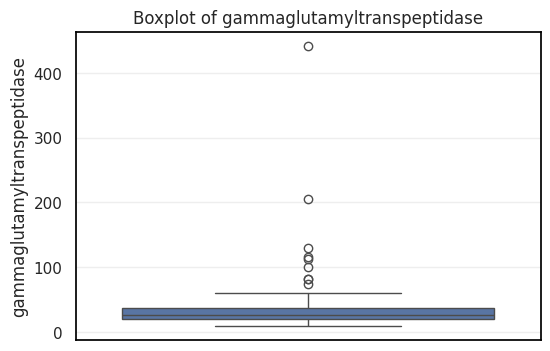

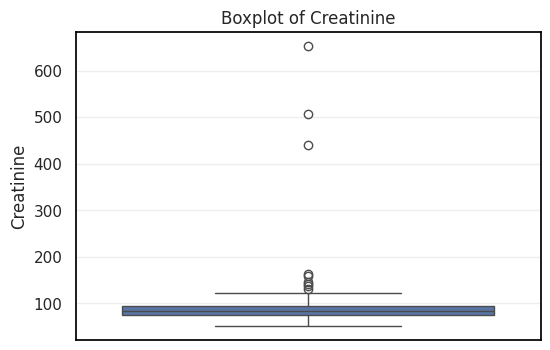

In [41]:
num_features = ['PV', 'PSA', 'fPSA', 'PSAD', 'FT', 'Age', 'BMI',
                'NLR', 'PLR', 'MLR', 'GLR', 'LSR', 'RPR', 'WBC',
                'RBC', 'Hb', 'RDW', 'Plt', 'Bloodglucose',
                'gammaglutamyltranspeptidase', 'Creatinine']

# Boxplots to check for outliers
for feature in num_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(df[feature])
    plt.title(f"Boxplot of {feature}")
    plt.show()

Pair Plot Analysis

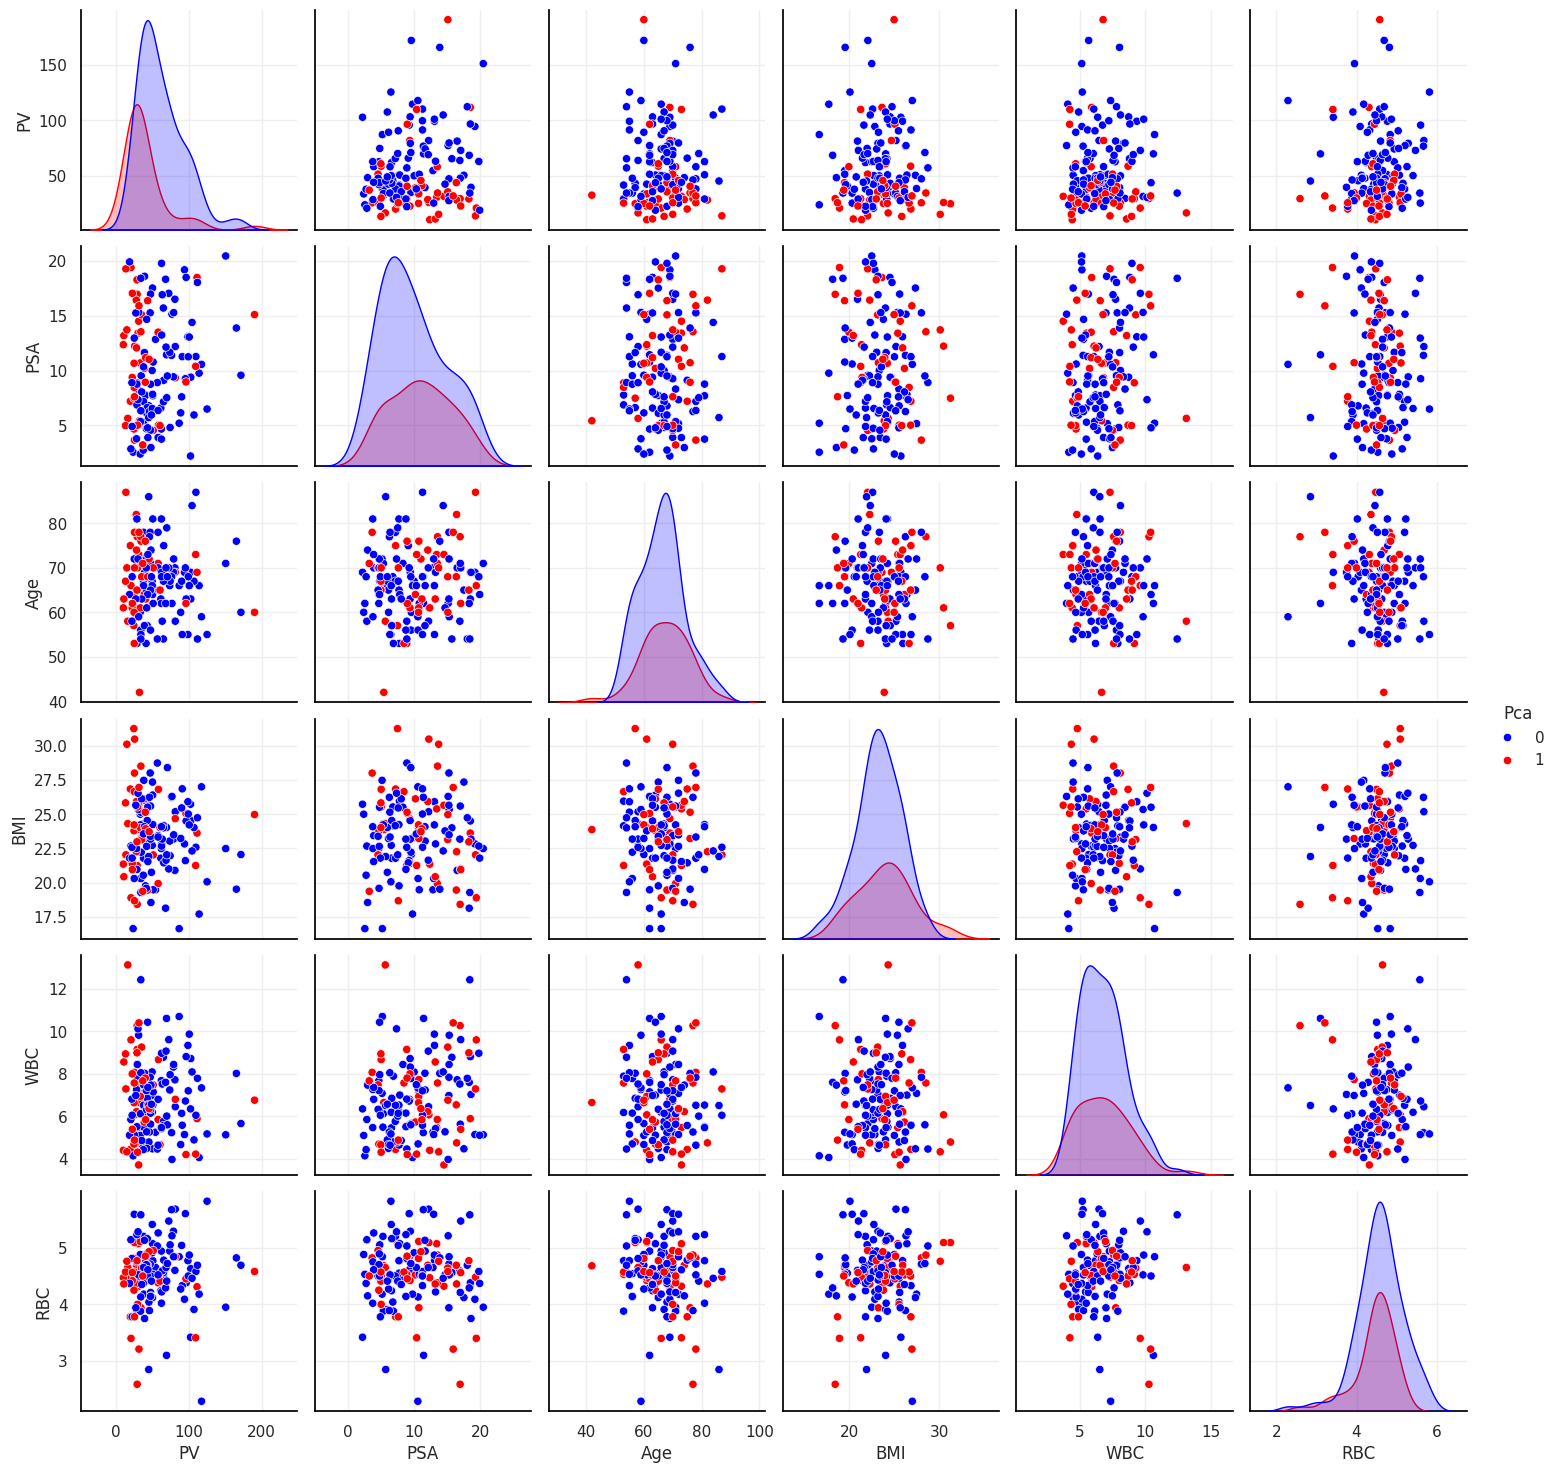

In [42]:
# Pairplot to examine relationships
selected_features = ['PV', 'PSA', 'Age', 'BMI', 'WBC', 'RBC', 'Pca']
palette = {0: 'blue', 1: 'red'}  # Map 0 to blue and 1 to red
sns.pairplot(df[selected_features], hue='Pca', diag_kind='kde', palette=palette)
plt.show()


# Model

In [43]:
scaler = StandardScaler()

Data Splitting

In [44]:
X = df.drop('Pca', axis = 1)
y = df['Pca']

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


Model Training

In [45]:
model = RandomForestClassifier(class_weight= 'balanced', random_state = 42, )


#Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Model Parameters:", grid_search.best_params_)

best_model.fit(X_train, y_train)

# Model Evaluation
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]





Fitting 5 folds for each of 720 candidates, totalling 3600 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Model Parameters: {'bootstrap': True, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


Model Evaluation

Training Set Performance:
Accuracy: 0.96
Precision: 0.97
Recall: 0.92
F1 Score: 0.94
AUC-ROC: 1.00

Validation Set Performance:
Accuracy: 0.82
Precision: 0.58
Recall: 0.70
F1 Score: 0.64
AUC-ROC: 0.82



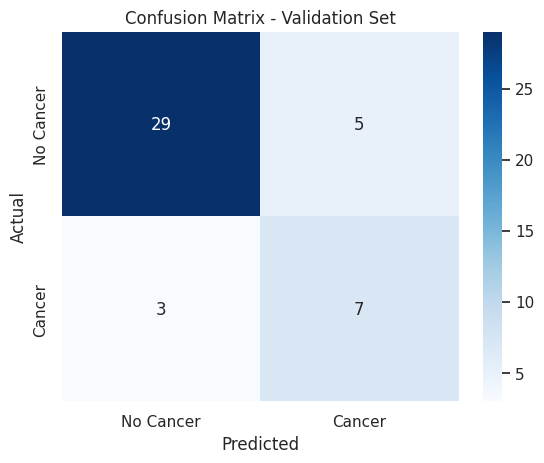

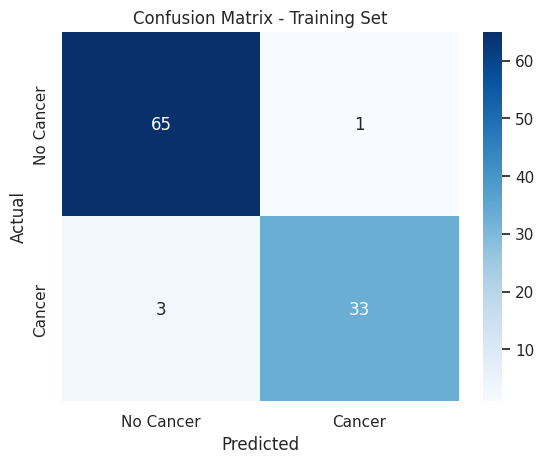

In [46]:
# Evaluate model on training set
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

# Training set metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)

print("Training Set Performance:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision: {train_precision:.2f}")
print(f"Recall: {train_recall:.2f}")
print(f"F1 Score: {train_f1:.2f}")
print(f"AUC-ROC: {train_roc_auc:.2f}")
print()

# Evaluate model on validation set
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Validation set metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print("Validation Set Performance:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1 Score: {test_f1:.2f}")
print(f"AUC-ROC: {test_roc_auc:.2f}")
print()

# Confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=['No Cancer', 'Cancer'], yticklabels=['No Cancer', 'Cancer'])
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion matrix for the training set
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['No Cancer', 'Cancer'], yticklabels=['No Cancer', 'Cancer'])
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


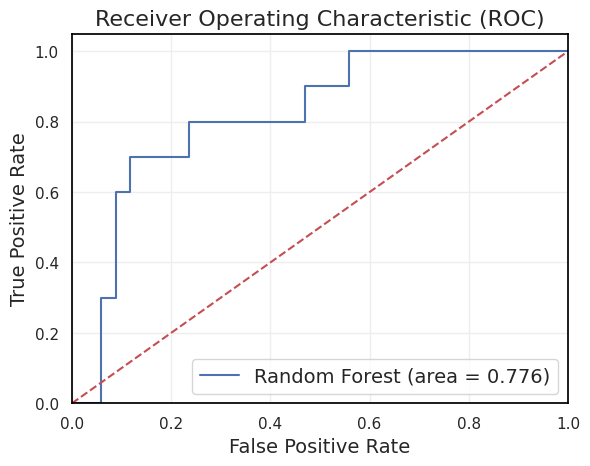

In [47]:
rf_roc_auc = roc_auc_score(y_test, best_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.3f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.savefig('RF_ROC')
plt.show()

In [57]:
import joblib

joblib.dump(best_model, 'RF_XAI_model.joblib')

['RF_XAI_model.joblib']

# Explainable AI (XAI)

SHAP

In [48]:
features = ['UrineWBC', 'UrineRBC', 'Ultrasoundhypoechoicnodules',
            'Prostaticcalculi', 'PV', 'PSA', 'fPSA', 'PSAD', 'FT', 'Age', 'BMI',
            'NLR', 'PLR', 'MLR', 'GLR', 'LSR', 'RPR', 'WBC', 'RBC', 'Hb', 'RDW',
            'Plt', 'Neutrophilcount', 'Lymphocytecount', 'Monocytecount',
            'Eosinophilcount', 'Bloodglucose', 'gammaglutamyltranspeptidase',
            'Creatinine']

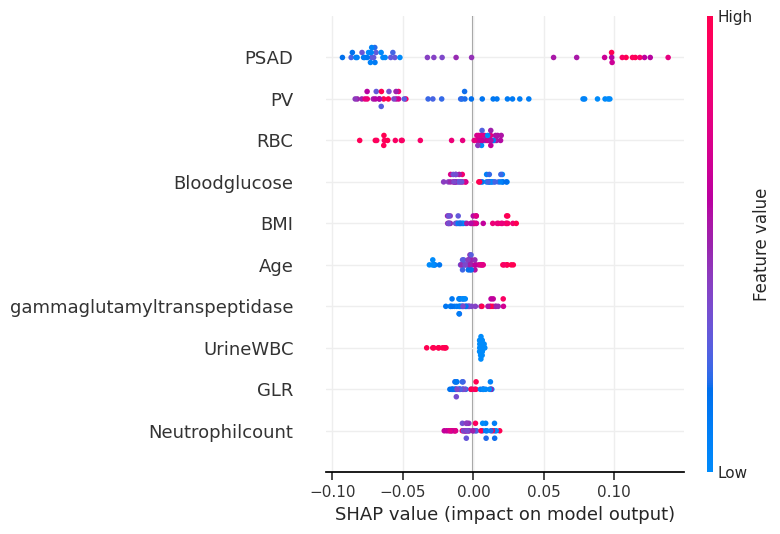

<Figure size 640x480 with 0 Axes>

runtime is 0.7318928241729736


In [49]:


start_time = time.time()
# Initialize SHAP
shap.initjs()


explainer = shap.TreeExplainer(best_model)

# SHAP values for the test data
samples = X_test
shap_values = explainer.shap_values(samples)

#  SHAP summary plot
shap.summary_plot(shap_values[:, :, 1], samples, max_display=10)

# Save the plot as a PNG file
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')

#  display the plot
plt.show()
end_time  = time.time()

print(f'runtime is {end_time - start_time}')



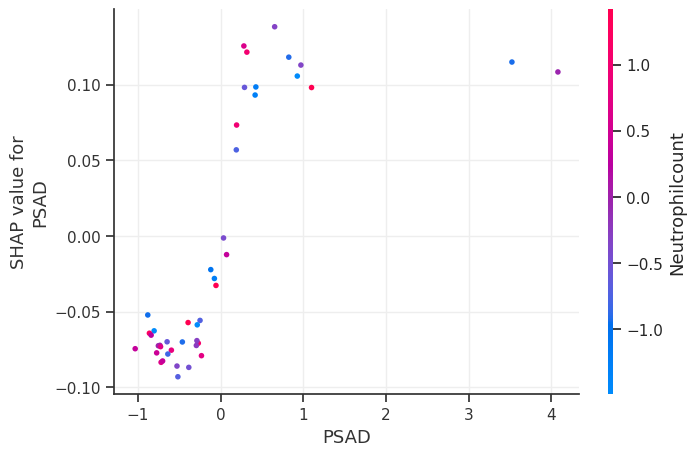

In [50]:
shap.dependence_plot('PSAD', shap_values[:, :, 1], samples)

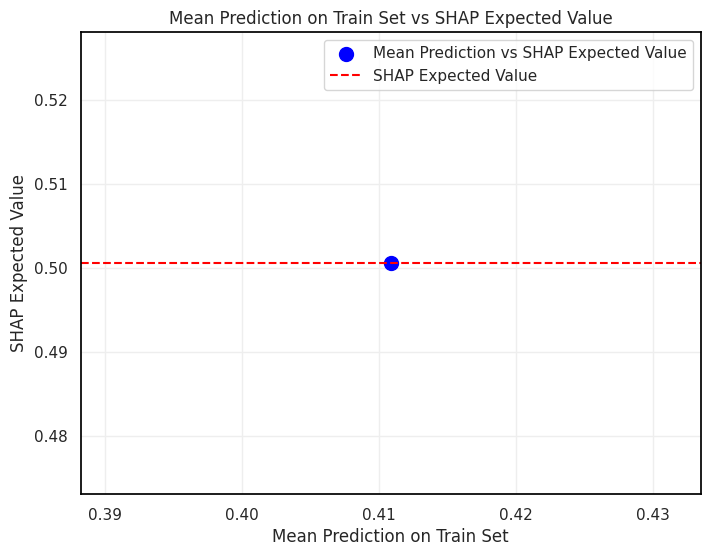

In [51]:
# Step 1: Calculate the Mean Prediction on Train Set
train_predictions = best_model.predict_proba(X_train)[:, 1]  # Assuming binary classification, get probability of class 1
mean_train_prediction = np.mean(train_predictions)

# Step 2: Get SHAP expected value
shap_expected_value = explainer.expected_value[1]

plt.figure(figsize=(8, 6))

# Plot the point
plt.scatter(mean_train_prediction, shap_expected_value, color='blue', label="Mean Prediction vs SHAP Expected Value", s=100)

# horizontal line for the SHAP expected value (just to show the baseline)
plt.axhline(y=shap_expected_value, color='red', linestyle='--', label="SHAP Expected Value")

plt.title("Mean Prediction on Train Set vs SHAP Expected Value")
plt.xlabel("Mean Prediction on Train Set")
plt.ylabel("SHAP Expected Value")

# Show the plot
plt.legend()
plt.show()

LIME (Local Interpretable Model-agnostic Explanations)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


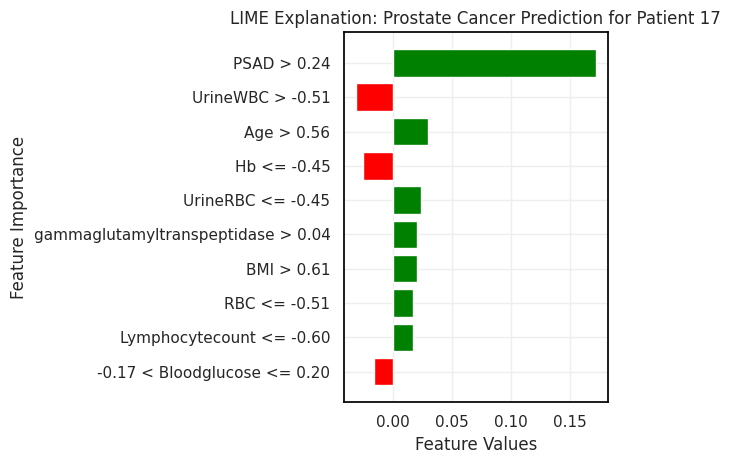

LIME explanation saved as 'lime_explanation_with_labels.png'
the runtime is 1.1573612689971924
Patient 17 has prostate cancer suspected


In [53]:


# Set up styling for plots to improve aesthetics
sns.set(style="whitegrid")  #  a clean grid style for the plots
plt.rcParams['axes.facecolor'] = 'white'  # background color for the plot
plt.rcParams['axes.edgecolor'] = 'black'  # edge color for axes
plt.rcParams['grid.color'] = '#eeeeee'  #  grid color

# X_train and X_test to numpy arrays
X_train_numpy = X_train.values
X_test_numpy = X_test.values

start = time.time()
# Initialize LIME Explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_numpy,
    feature_names=features,
    class_names=['No Cancer', 'Cancer'],
    mode='classification',
    discretize_continuous=True  # Ensure continuous features are discretized
)

# Selection of  a sample index to explain (e.g., the 17th sample in X_test)
sample_index = 17

# Explain the prediction for the selected sample
exp = lime_explainer.explain_instance(X_test_numpy[sample_index], best_model.predict_proba)

# a static matplotlib figure for the explanation
fig = exp.as_pyplot_figure()

# labels, titles, and other information
plt.title(f"LIME Explanation: Prostate Cancer Prediction for Patient {sample_index}")
plt.xlabel("Feature Values")
plt.ylabel("Feature Importance")
plt.tight_layout()

# Save the figure as a PNG file
plt.savefig(f"lime_explanation_for patient {sample_index}.png", dpi=300, bbox_inches='tight')

# Optionally, show the plot (this will be the saved PNG)
plt.show()

print("LIME explanation saved as 'lime_explanation_with_labels.png'")


end = time.time()
print(f"the runtime is {end-start}")


pred = best_model.predict(X_test[sample_index:sample_index+1])
if pred == 0:
    print(f"Patient {sample_index} has no prostate cancer suspected")
    actual_prediction = 'No Cancer'
else:
    print(f"Patient {sample_index} has prostate cancer suspected")
    actual_prediction = 'Cancer'

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X

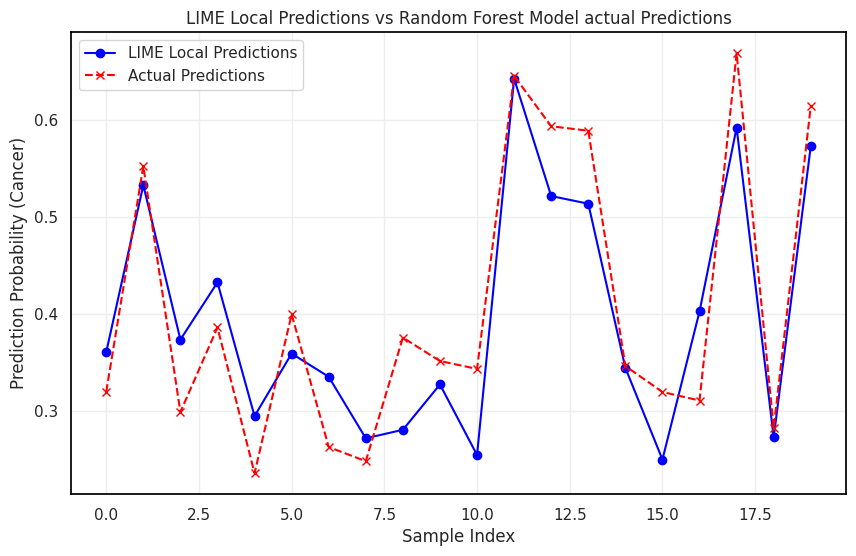

In [54]:
#comparing LIMW Prediction with RF model prediction

# 1. Select a subset of the test dataset (for example, the first 20 samples)
sample_size = 20  # Choose a reasonable number of samples to visualize
X_test_subset = X_test[:sample_size].values  # Convert to numpy if it's a pandas DataFrame
y_test_subset = y_test[:sample_size].values  # Convert to numpy if it's a pandas DataFrame

# Ensure X_train is a numpy array for LIME
X_train = np.array(X_train)  # Convert to numpy if it's a pandas DataFrame

# 2. Generate local predictions using LIME for each sample in the subset
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=features,
    class_names=['No Cancer', 'Cancer'],
    mode='classification'
)

# List to store the local predictions from LIME
lime_predictions = []

# Loop through each sample and explain it using LIME
for i in range(sample_size):
    exp = lime_explainer.explain_instance(X_test_subset[i], best_model.predict_proba)
    lime_pred = exp.local_pred # Probability of class 'Cancer'
    lime_predictions.append(lime_pred)

# 3. actual predictions for the same samples from the trained model
actual_predictions = best_model.predict_proba(X_test_subset)[:, 1]  # Probability of class 'Cancer'

# 4. Plot the comparison (Local Prediction vs Actual Prediction)
plt.figure(figsize=(10, 6))
plt.plot(range(sample_size), lime_predictions, label='LIME Local Predictions', marker='o', color='blue')
plt.plot(range(sample_size), actual_predictions, label='Actual Predictions', marker='x', color='red', linestyle='--')
plt.title('LIME Local Predictions vs Random Forest Model actual Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Prediction Probability (Cancer)')
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig('LIME Local Predictions vs Random Forest Model actual Predictions.png')
plt.show()



Feature Importance Visualization

<ipython-input-55-44f17eca66a8>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='coolwarm')


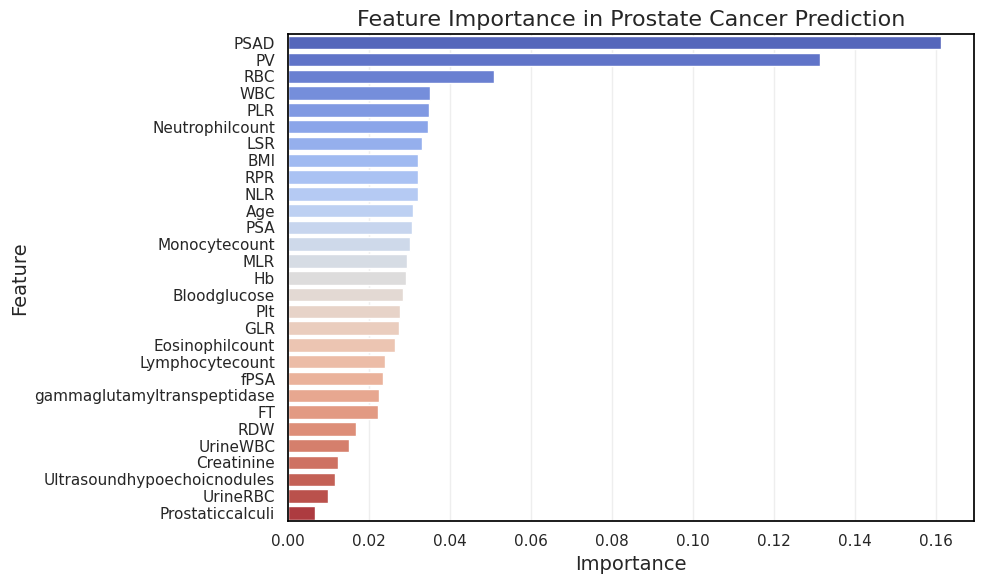

In [55]:
# Calculate Feature Importance
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Feature Importance Bar Plot with Improved Aesthetics
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='coolwarm')
plt.title("Feature Importance in Prostate Cancer Prediction", fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.savefig('Feature Importance.png')
plt.tight_layout()
plt.show()

In [60]:
pip install -r requirements.txt
